# Generation and post-analysis in aids dataset

In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [3]:
%matplotlib inline

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

### Experiment setting - links to data

In [4]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

## Statistical analysis with original data

In [5]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,1,1,1,0,100,169.0,39.0,34
1,287,0,1,2,2,0,90,149.5,15.0,34
2,199,0,1,1,1,0,90,46.0,53.0,48
3,270,0,1,1,2,0,100,54.5,6.0,51
4,276,0,1,1,1,0,100,95.0,7.0,34


In [6]:
aids_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')

In [7]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]

In [8]:
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
aids_control_columns

['time',
 'censor',
 'strat2',
 'sex',
 'raceth',
 'ivdrug',
 'karnof',
 'cd4',
 'priorzdv',
 'age']

### Data loading and Feature analysis treated/control

In [9]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [10]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [11]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [12]:
df_transformed_all.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age', 'treatment'],
      dtype='object')

In [13]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,189.0,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,287.0,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,199.0,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,270.0,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,276.0,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


In [14]:
df_transformed_all.shape

(1151, 11)

In [15]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 10


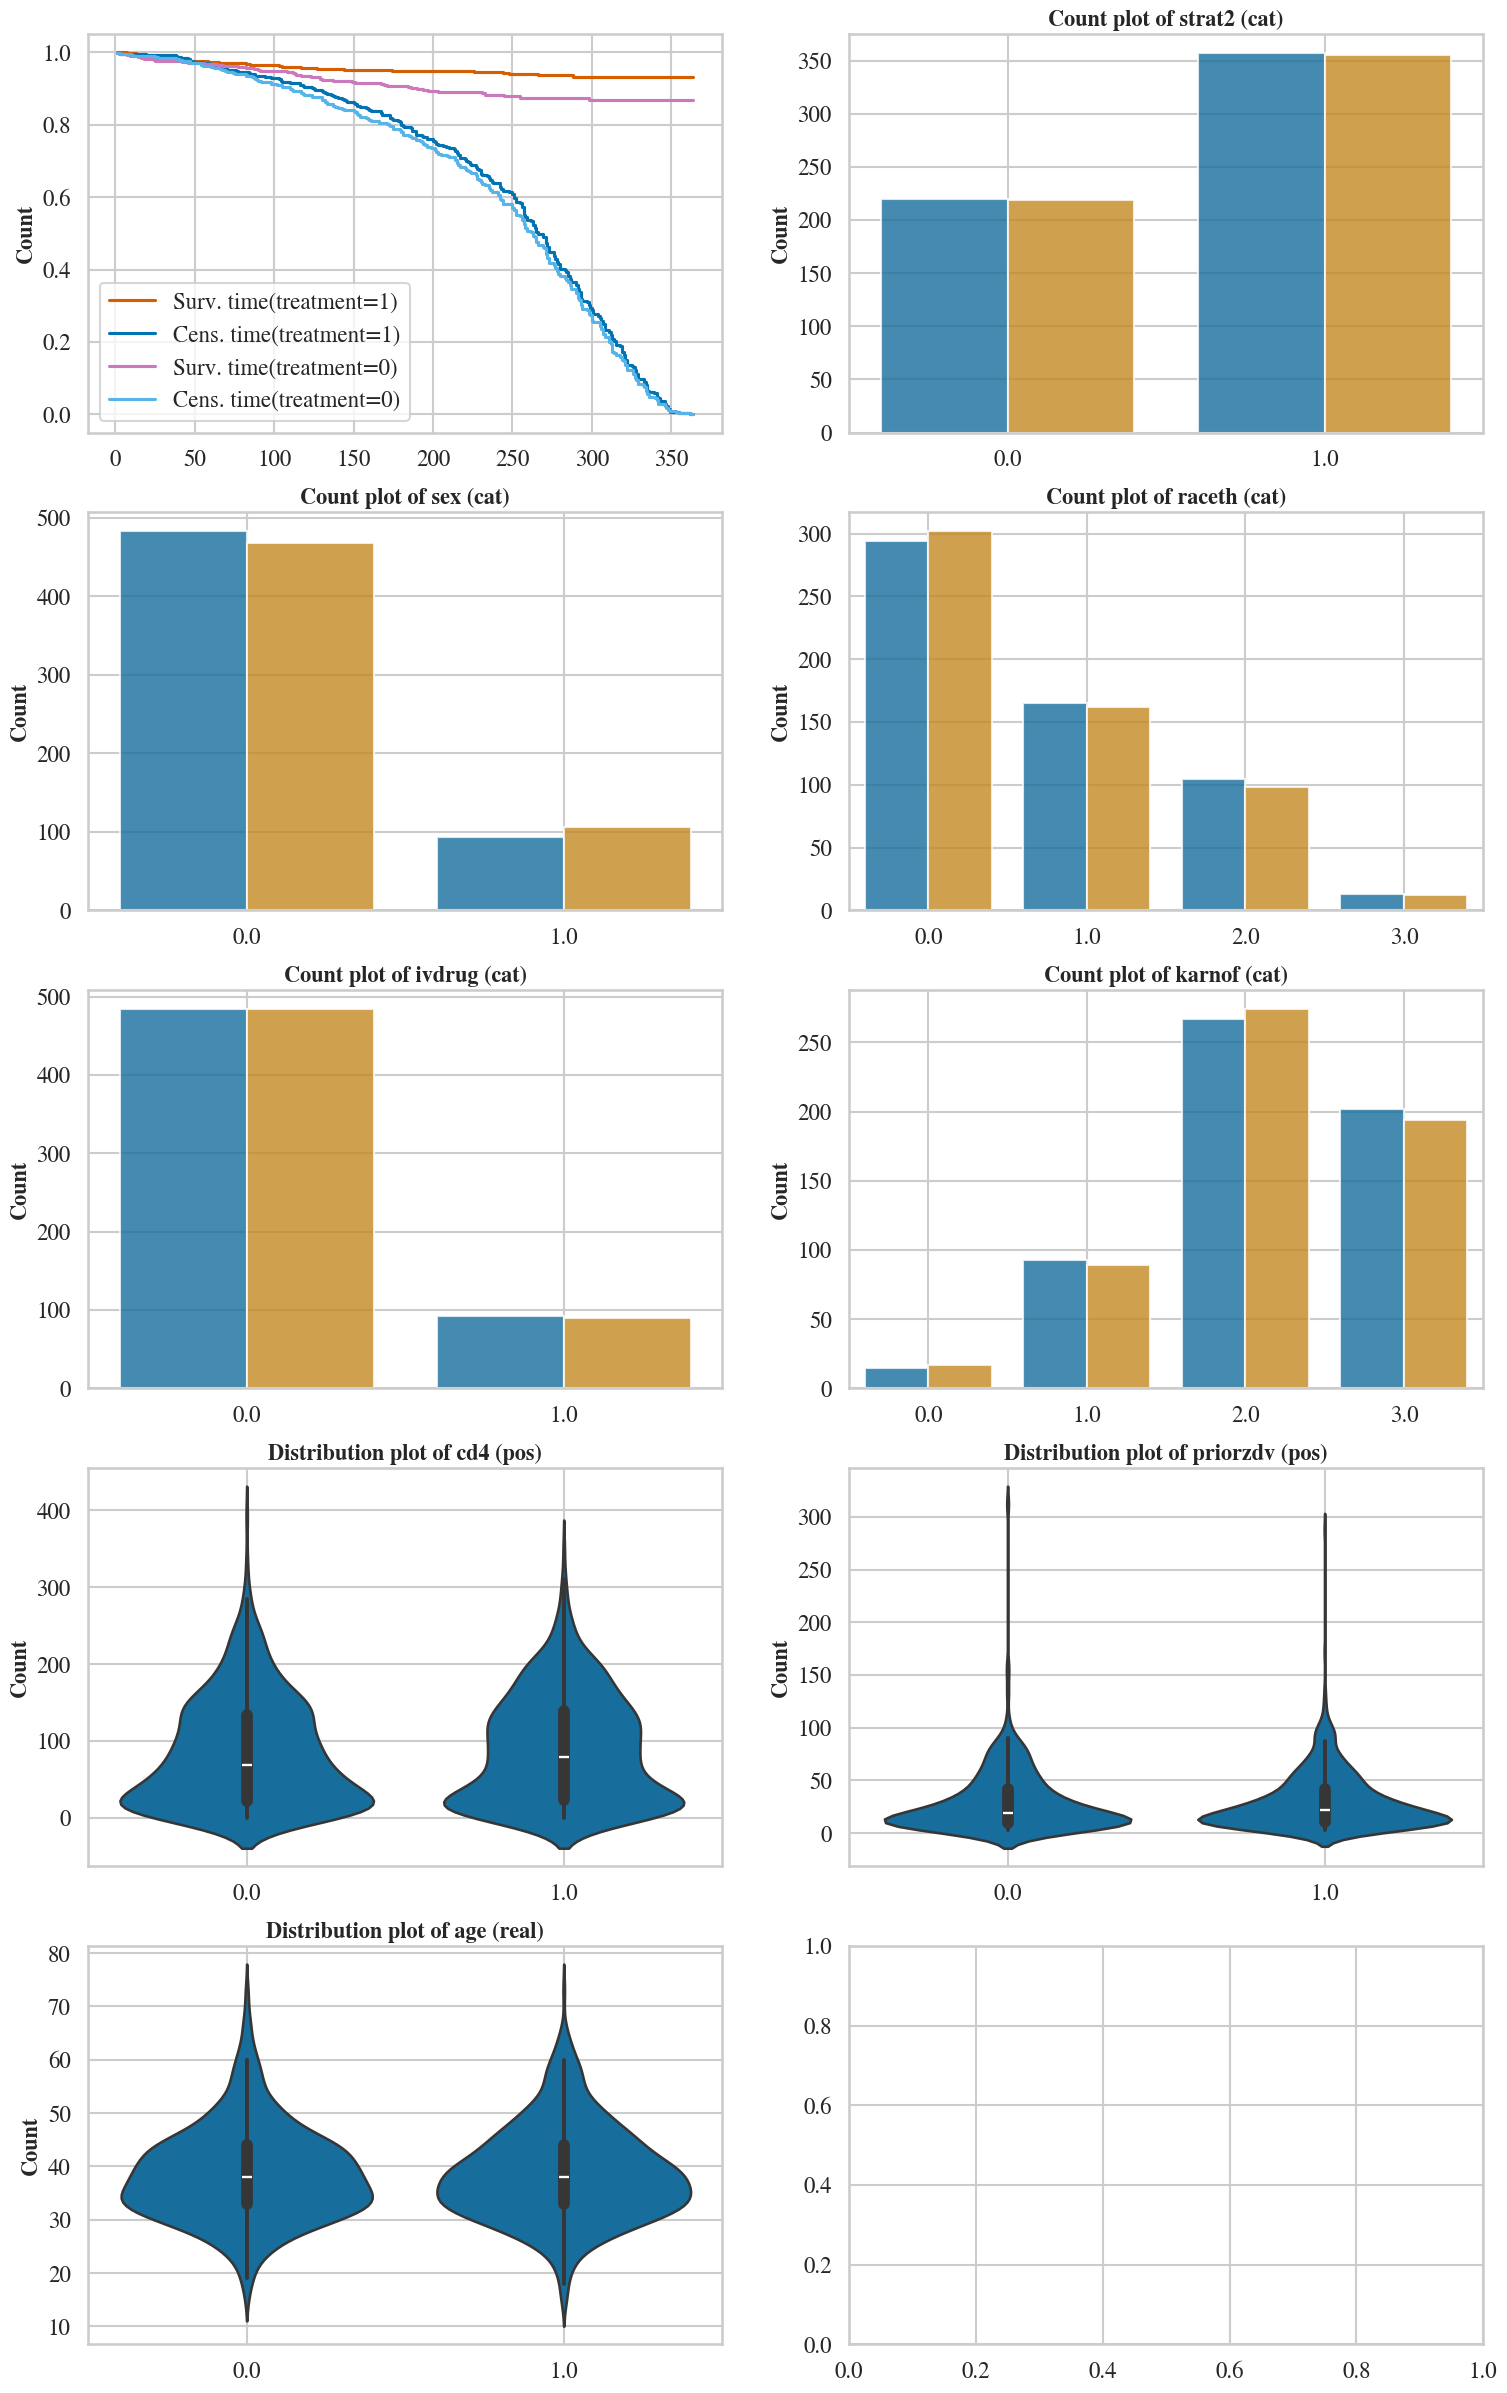

In [16]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [17]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [18]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

## Training VAE

### Experiment setting

In [19]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [20]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 200
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [21]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.1533, ELBO_train: -21.99597206, KL_z: 1.51478419, KL_s: 0.07848768, reconstruction loss: -20.40270019
Epoch: [100]  time: 3.4484, ELBO_train: -17.63888435, KL_z: 0.65969998, KL_s: 0.03897548, reconstruction loss: -16.94020890
Training finished.


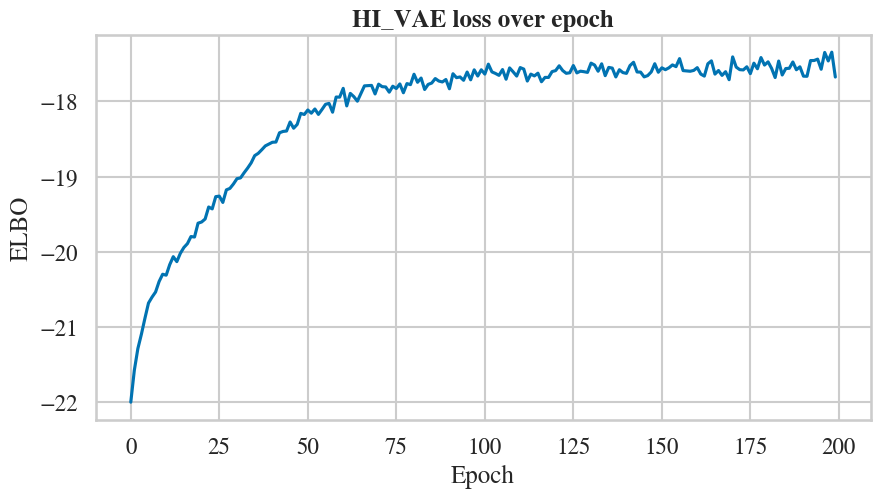

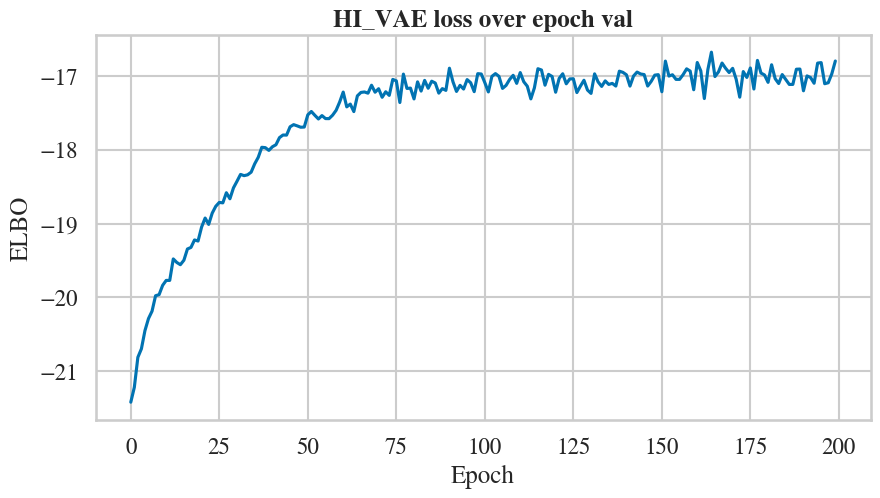

In [22]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [23]:
#visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
#                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

## Generated samples from control dataset

In [24]:
data.shape

torch.Size([577, 19])

In [25]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [26]:
miss_mask_forgen.shape

torch.Size([577, 9])

In [27]:
data_forgen.shape

torch.Size([577, 19])

#### Generate from original sample

In [28]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 100

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

577


### Statistical analysis with simulated vs initial control data

In [29]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [30]:
df_transformed_generated

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,sample
0,319.518738,0.0,1.0,0.0,0.0,0.0,2.0,84.014328,65.454857,39.250217,0
1,196.229706,0.0,1.0,0.0,2.0,0.0,3.0,45.619930,19.889755,35.491486,0
2,245.156860,1.0,1.0,0.0,2.0,0.0,1.0,68.255630,46.974442,40.912548,0
3,151.851730,1.0,0.0,0.0,1.0,0.0,1.0,19.656467,27.753405,43.824688,0
4,364.000000,0.0,1.0,0.0,1.0,0.0,1.0,89.667297,63.228626,36.719547,0
...,...,...,...,...,...,...,...,...,...,...,...
572,343.581879,0.0,1.0,0.0,2.0,0.0,0.0,52.401676,20.758057,29.390936,0
573,313.421234,0.0,1.0,0.0,0.0,0.0,2.0,12.908366,41.679764,34.321426,0
574,97.748291,0.0,0.0,0.0,2.0,0.0,2.0,28.375788,14.033670,25.242710,0
575,340.041626,0.0,1.0,0.0,1.0,0.0,3.0,289.675049,49.267365,44.470718,0


comparison variable sample 10


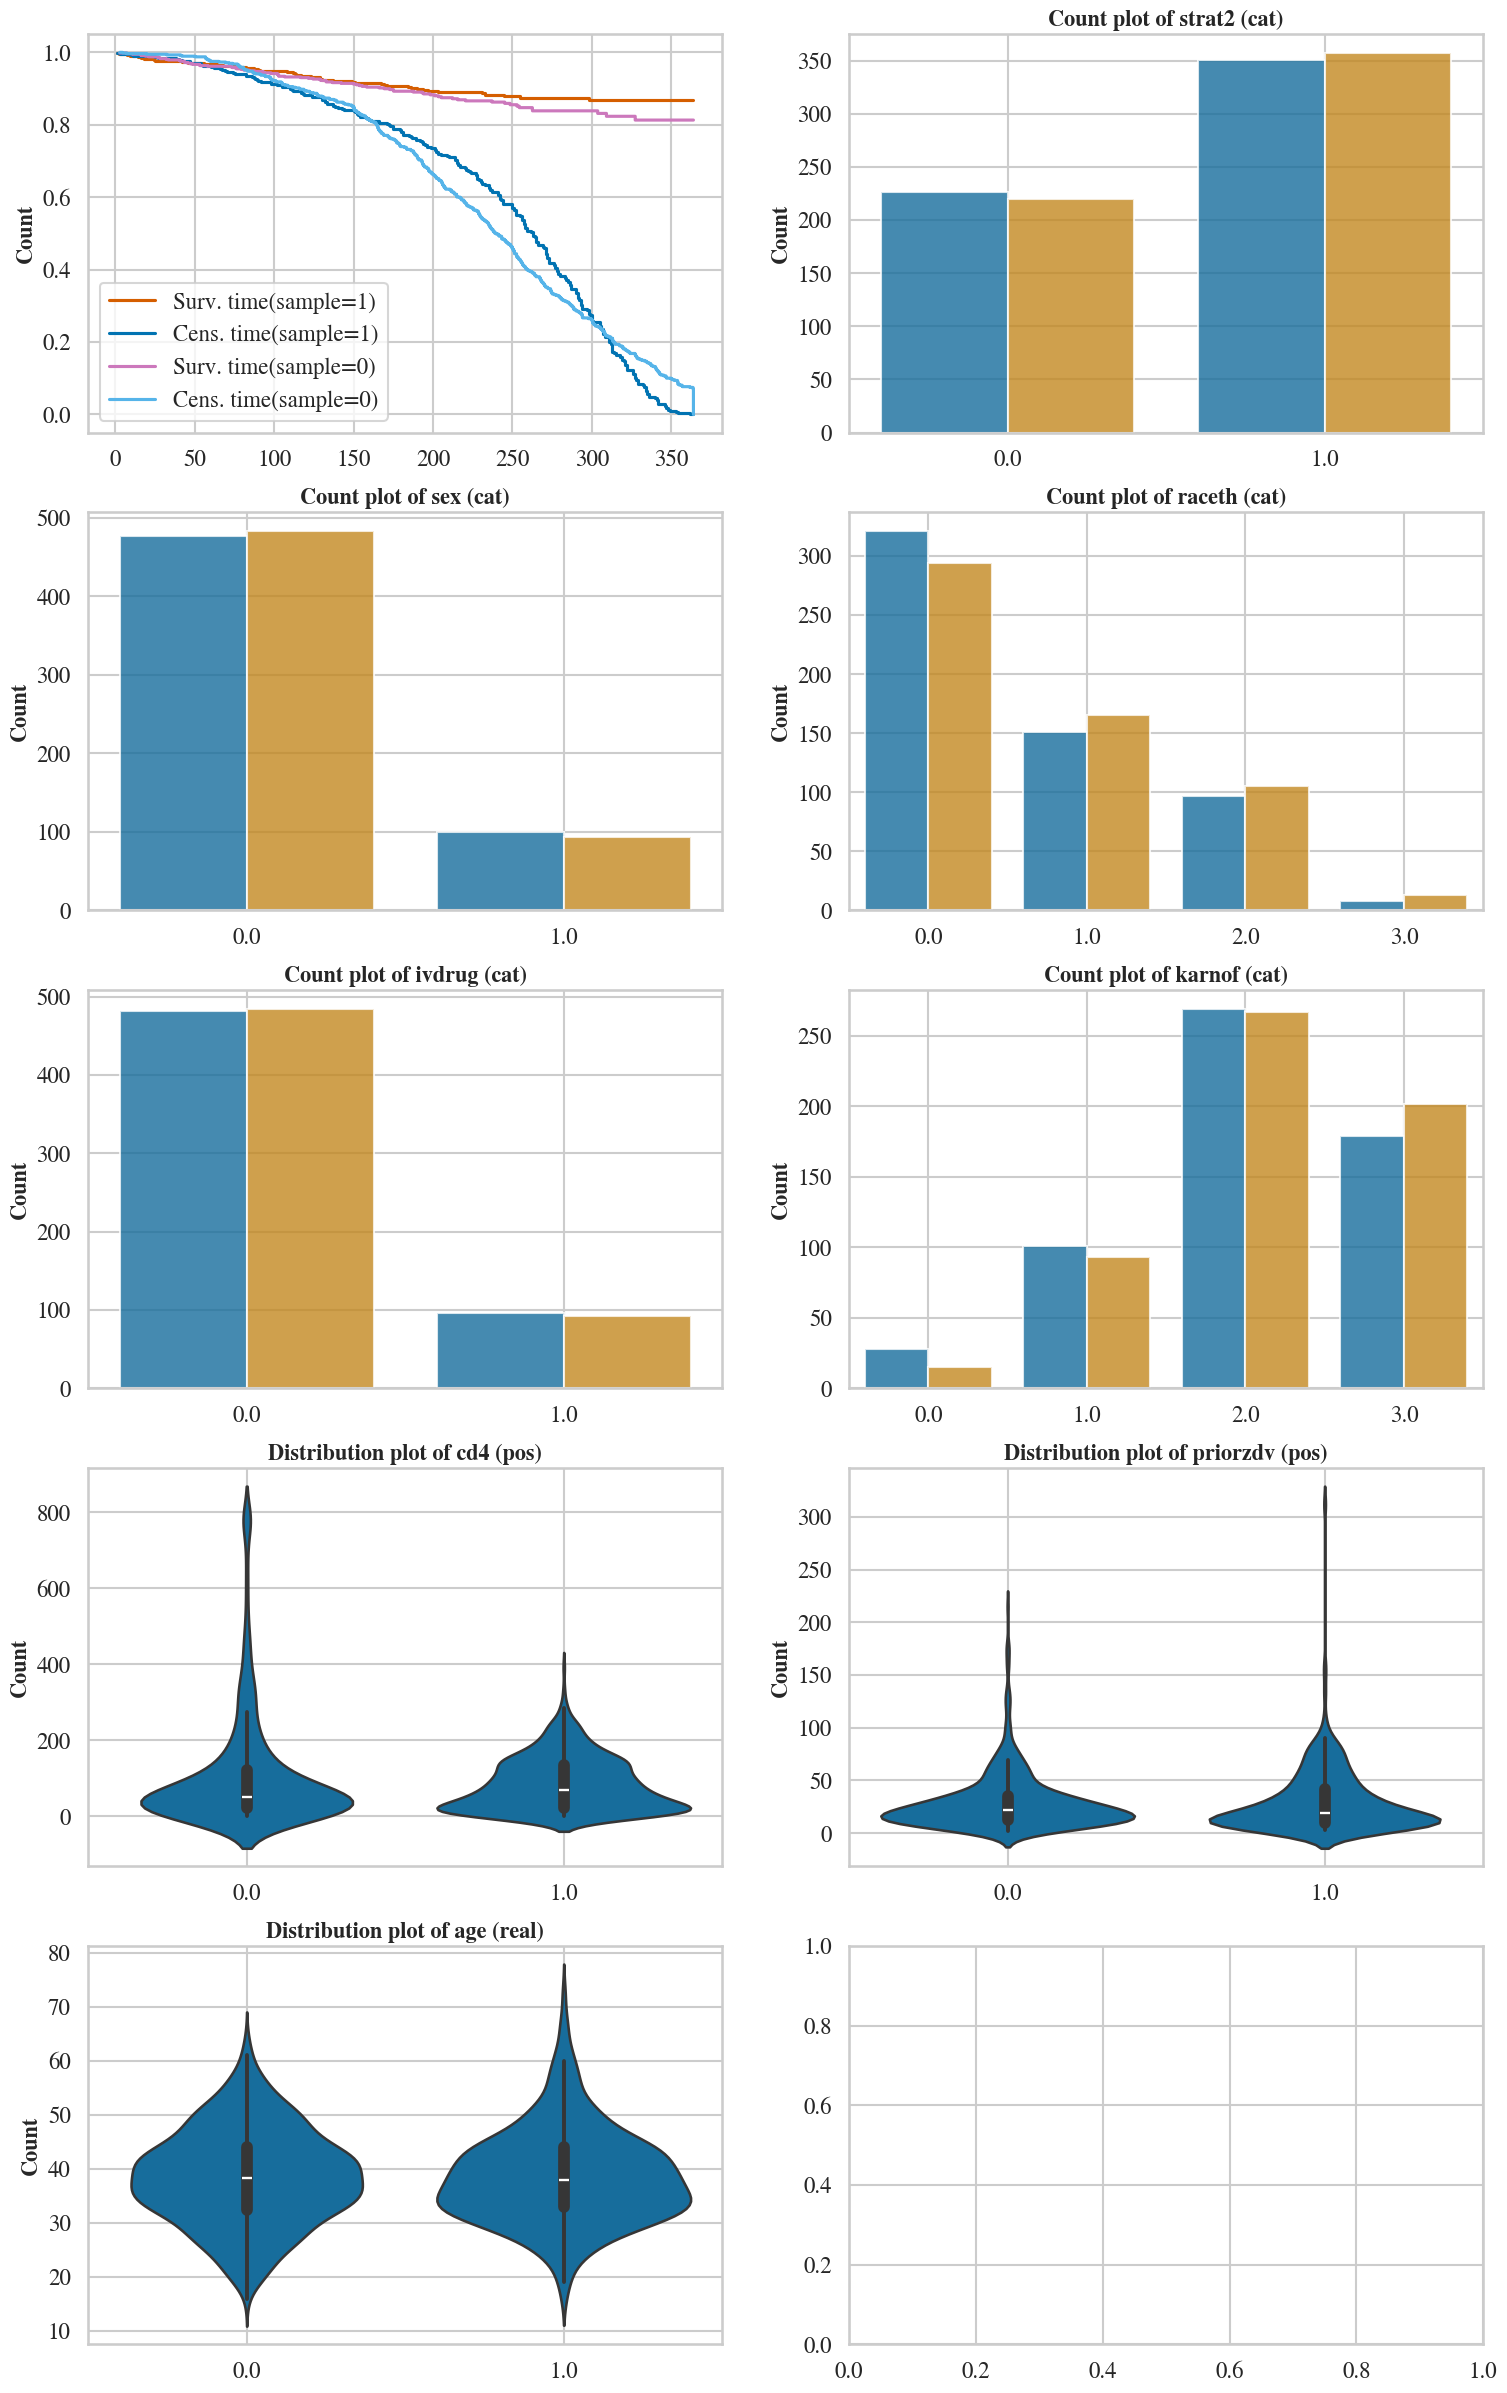

In [31]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [32]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [33]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  235.9 [156.7,293.0]  221.4 [155.5,287.9]  251.0 [158.0,298.0]   0.067
censor, n (%)            0.0                            1014 (87.9)           500 (86.7)           514 (89.1)   0.241
                         1.0                             140 (12.1)            77 (13.3)            63 (10.9)        
strat2, n (%)            0.0                             446 (38.6)           226 (39.2)           220 (38.1)   0.762
                         1.0                             708 (61.4)           351 (60.8)           357 (61.9)        
sex, n (%)               0.0                            

### Statistical analysis: generated control x initial treated

In [34]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=aids_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [35]:
#df_transformed_all.head()

In [36]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

In [37]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  247.8 [173.8,299.7]  226.9 [166.4,291.2]  263.0 [187.0,305.0]   0.001
censor, n (%)            0.0                               1041 (90.4)           500 (86.7)           541 (94.3)  <0.001
                         1.0                                 110 (9.6)            77 (13.3)             33 (5.7)        
strat2, n (%)            0.0                                462 (40.1)           243 (42.1)           219 (38.2)   0.190
                         1.0                                689 (59.9)           334 (57.9)           355 (61.8)        
sex, n (%)               0.0    

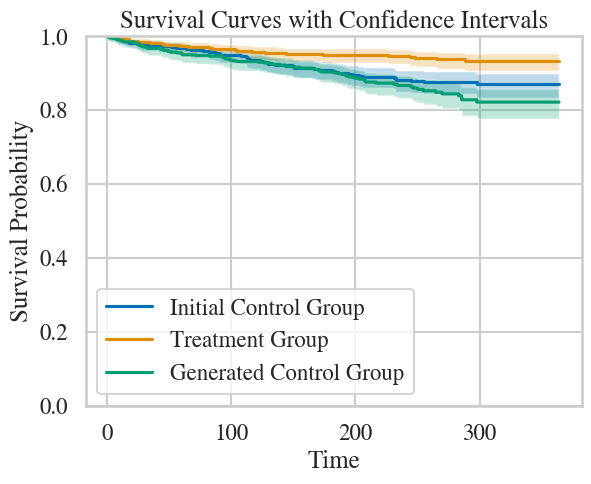

In [38]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [39]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']

Initial Cox model

In [40]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [41]:
number_column_treatment = 6 # in X_initial

In [42]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-1.51111787e-02,  2.03117243e-01, -5.55172796e-01, -1.46215358e-02,
       -7.93512048e-04,  2.40314802e-02, -6.66311702e-01, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

Tests in all generated datasets

In [43]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


In [44]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

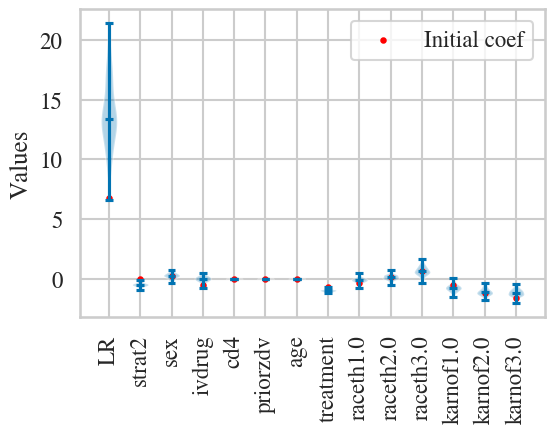

In [45]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

### Log rank test

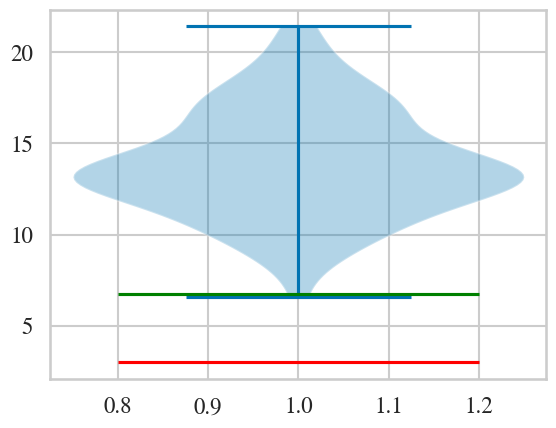

In [46]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

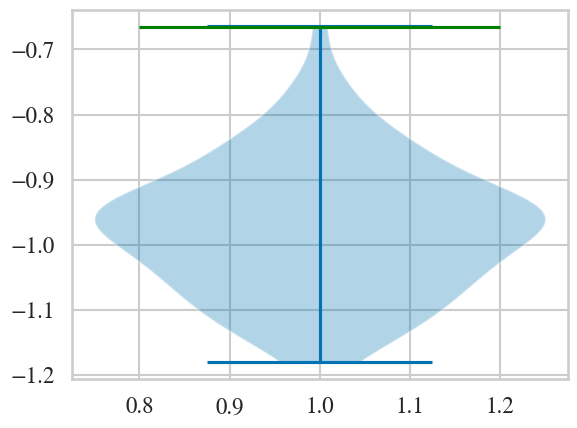

In [47]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

## Stratified w.r. CD4 count analysis

In [48]:
data_trans

tensor([[328.5827,   0.0000,   1.0000,  ..., 409.2574,  33.8261,  49.0568],
        [152.7896,   1.0000,   1.0000,  ...,  14.5641,  23.7531,  35.4672],
        [207.3707,   0.0000,   1.0000,  ..., 784.0000,  35.5049,  44.8071],
        ...,
        [230.5380,   0.0000,   1.0000,  ...,  26.4093,  10.9544,  35.0618],
        [169.9545,   0.0000,   1.0000,  ..., 107.6308,  25.1959,  35.3225],
        [117.0294,   0.0000,   1.0000,  ..., 203.9984,  25.5338,  39.6202]])

In [49]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [50]:
cd4_threshold = 50
df_transformed_all_oh_lowcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] <= cd4_threshold]
print(df_transformed_all_oh_lowcd4.shape)
X_initial_lowcd4 = df_transformed_all_oh_lowcd4.to_numpy()[:,2:15]
Y_initial_lowcd4 = Surv.from_arrays(df_transformed_all_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_all_oh_lowcd4.to_numpy()[:,0]) 
df_transformed_all_oh_highcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] > cd4_threshold]
print(df_transformed_all_oh_highcd4.shape)
X_initial_highcd4 = df_transformed_all_oh_highcd4.to_numpy()[:,2:15]
Y_initial_highcd4 = Surv.from_arrays(df_transformed_all_oh_highcd4.to_numpy()[:,1]==1,df_transformed_all_oh_highcd4.to_numpy()[:,0]) 

(459, 15)
(692, 15)


In [51]:
cox_initial_lowcd4 = CoxPHSurvivalAnalysis()
cox_initial_lowcd4.fit(X_initial_lowcd4,Y_initial_lowcd4)
cox_initial_highcd4 = CoxPHSurvivalAnalysis()
cox_initial_highcd4.fit(X_initial_highcd4,Y_initial_highcd4)


CoxPHSurvivalAnalysis()

In [52]:
feat_types_dict_all

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'}]

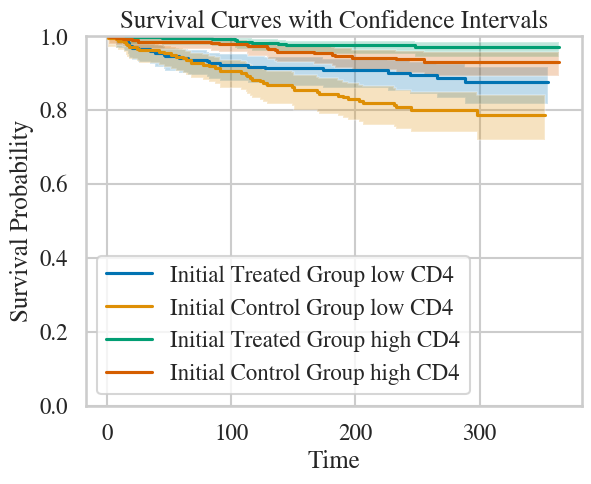

In [53]:
time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, conf_int_initial_lowcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, conf_int_initial_lowcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_highcd4_T, survival_prob_initial_highcd4_T, conf_int_initial_highcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


time_initial_highcd4_C, survival_prob_initial_highcd4_C, conf_int_initial_highcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

plt.step(time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, where="post", label="Initial Treated Group low CD4")
plt.fill_between(time_initial_lowcd4_T, conf_int_initial_lowcd4_T[0], conf_int_initial_lowcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, where="post", label="Initial Control Group low CD4")
plt.fill_between(time_initial_lowcd4_C, conf_int_initial_lowcd4_C[0], conf_int_initial_lowcd4_C[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_T, survival_prob_initial_highcd4_T, where="post", label="Initial Treated Group high CD4")
plt.fill_between(time_initial_highcd4_T, conf_int_initial_highcd4_T[0], conf_int_initial_highcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_C, survival_prob_initial_highcd4_C, where="post", label="Initial Control Group high CD4")
plt.fill_between(time_initial_highcd4_C, conf_int_initial_highcd4_C[0], conf_int_initial_highcd4_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

In [54]:
compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])

(np.float64(5.535873093721627), np.float64(0.018630467405504756))

In [55]:
compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])

(np.float64(4.395519026726351), np.float64(0.03603349014270788))

In [56]:
coef_treat_lowcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
coef_treat_highcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    df_transformed_T_Cgen_oh_lowcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] <= cd4_threshold]
    X_gen_lowcd4 = df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,2:15]
    Y_gen_lowcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,0]) 
    df_transformed_T_Cgen_oh_highcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] > cd4_threshold]
    X_gen_highcd4 = df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,2:15]
    Y_gen_highcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,0]) 
    
    coef_treat_lowcd4[i,0] = -np.log(compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])[1])
    cox_generated_lowcd4 = CoxPHSurvivalAnalysis()
    cox_generated_lowcd4.fit(X_gen_lowcd4,Y_gen_lowcd4)
    coef_treat_lowcd4[i,1:] = cox_generated_lowcd4.coef_[:]

    coef_treat_highcd4[i,0] = -np.log(compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])[1])
    cox_generated_highcd4 = CoxPHSurvivalAnalysis()
    cox_generated_highcd4.fit(X_gen_highcd4,Y_gen_highcd4)
    coef_treat_highcd4[i,1:] = cox_generated_highcd4.coef_[:]


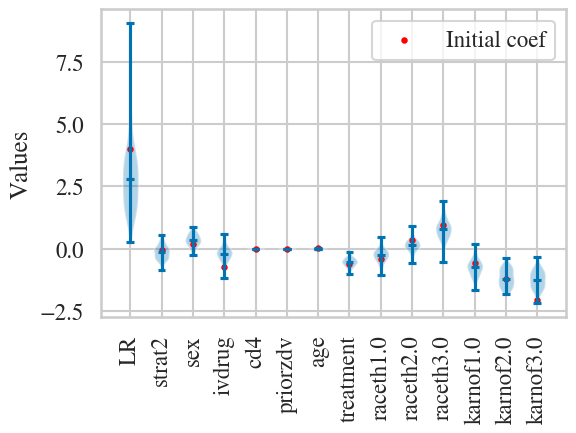

In [57]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_lowcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_lowcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_lowcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_lowcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

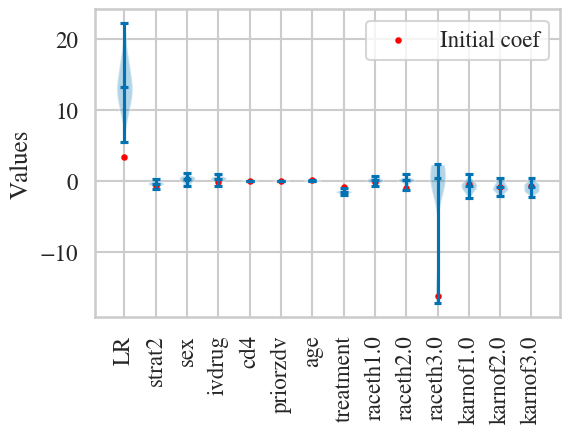

In [58]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_highcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_highcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_highcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_highcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [59]:

compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])

(np.float64(20.872659128865163), np.float64(4.908510227082737e-06))

# Metrics from synthcity

All the metrics available in synthcity are detailled here: [https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics](https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics) 

In [60]:
from synthcity.metrics.eval import Metrics
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader

Metrics().list()

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


{'sanity': ['data_mismatch',
  'common_rows_proportion',
  'nearest_syn_neighbor_distance',
  'close_values_probability',
  'distant_values_probability'],
 'stats': ['jensenshannon_dist',
  'chi_squared_test',
  'inv_kl_divergence',
  'ks_test',
  'max_mean_discrepancy',
  'wasserstein_dist',
  'prdc',
  'alpha_precision',
  'survival_km_distance',
  'fid'],
 'performance': ['linear_model',
  'mlp',
  'xgb',
  'linear_model_augmentation',
  'mlp_augmentation',
  'xgb_augmentation',
  'feat_rank_distance'],
 'detection': ['detection_xgb',
  'detection_mlp',
  'detection_gmm',
  'detection_linear'],
 'privacy': ['delta-presence',
  'k-anonymization',
  'k-map',
  'distinct l-diversity',
  'identifiability_score',
  'DomiasMIA_BNAF',
  'DomiasMIA_KDE',
  'DomiasMIA_prior']}

In [61]:
list_df_transformed_generated = []
for j in range(n_generated_sample):
    df_transformed_generated_j = pd.DataFrame(est_data_gen_transformed[j].numpy(), columns=aids_control_columns)
    df_transformed_generated_j['treatment'] = 0
    list_df_transformed_generated.append(df_transformed_generated_j)

#### Comparison of one generated dataset with the initial one

In [62]:
X_gt = SurvivalAnalysisDataLoader(
    df_transformed_initial,
    target_column="censor",
    time_to_event_column="time",
)

X_syn = SurvivalAnalysisDataLoader(
    list_df_transformed_generated[0],
    target_column="censor",
    time_to_event_column="time",
)

scores = Metrics().evaluate(X_gt=X_gt, # can be dataloaders or dataframes
                            X_syn=X_syn, 
                            reduction='mean', # default mean
                            n_histogram_bins=10, # default 10
                            metrics=None, # all metrics
                            task_type='survival_analysis', 
                            use_cache=True)

In [63]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

scores

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.089991,0.089991,0.089991,0.0,0.089991,0.0,1,0,0.00,minimize
sanity.close_values_probability.score,0.930676,0.930676,0.930676,0.0,0.930676,0.0,1,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.001733,0.001733,0.0,0.001733,0.0,1,0,0.00,minimize
stats.max_mean_discrepancy.joint,0.003466,0.003466,0.003466,0.0,0.003466,0.0,1,0,0.01,minimize
stats.wasserstein_dist.joint,0.095229,0.095229,0.095229,0.0,0.095229,0.0,1,0,0.07,minimize
stats.prdc.precision,0.928943,0.928943,0.928943,0.0,0.928943,0.0,1,0,0.01,maximize
stats.prdc.recall,0.987868,0.987868,0.987868,0.0,0.987868,0.0,1,0,0.01,maximize
stats.prdc.density,0.876256,0.876256,0.876256,0.0,0.876256,0.0,1,0,0.01,maximize
stats.prdc.coverage,0.902946,0.902946,0.902946,0.0,0.902946,0.0,1,0,0.01,maximize


#### Comparison of the 'n_generated_samples' synthetic datasets with the initial one

In [64]:
# Un peu long de run toutes les métriques sur les 100 échantillons générés donc je ne fais que sur 
# les 20 premiers ici (mais à terme peut être que toutes les métriques ne sont pas nécessaires).

In [65]:
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

X_gt = SurvivalAnalysisDataLoader(
    df_transformed_initial,
    target_column="censor",
    time_to_event_column="time",
    )

scores = ScoreEvaluator()
for j in range(20):
# for j in range(n_generated_sample):
    enable_reproducible_results(j)
    clear_cache()

    X_syn = SurvivalAnalysisDataLoader(
        list_df_transformed_generated[j],
        target_column="censor",
        time_to_event_column="time",
        )

    evaluation = Metrics().evaluate(X_gt=X_gt, # can be dataloaders or dataframes
                        X_syn=X_syn, 
                        reduction='mean', # default mean
                        n_histogram_bins=10, # default 10
                        metrics=None, # all metrics
                        task_type='survival_analysis', 
                        use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(
            key,
            mean_score[key],
            errors[key],
            duration[key],
            direction[key],
        )

out = scores.to_dataframe()

In [66]:
out

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,20,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.076752,0.161745,0.102643,1.921876e-02,0.099013,1.441694e-02,20,0,0.00,minimize
sanity.close_values_probability.score,0.741768,0.958406,0.910832,4.918004e-02,0.925477,3.119584e-02,20,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.006932,0.002513,1.282379e-03,0.001733,1.733102e-03,20,0,0.00,minimize
stats.max_mean_discrepancy.joint,0.003466,0.003467,0.003466,1.081680e-07,0.003466,9.799549e-09,20,0,0.01,minimize
stats.wasserstein_dist.joint,0.079640,0.095666,0.088743,4.895674e-03,0.088426,7.941006e-03,20,0,0.06,minimize
stats.prdc.precision,0.916811,0.948007,0.933536,8.388555e-03,0.933276,1.083189e-02,20,0,0.01,maximize
stats.prdc.recall,0.975737,0.994801,0.986655,5.955924e-03,0.987868,8.665511e-03,20,0,0.01,maximize
stats.prdc.density,0.846447,0.927210,0.884645,1.952018e-02,0.879029,2.547660e-02,20,0,0.01,maximize
stats.prdc.coverage,0.883882,0.946274,0.913778,1.512746e-02,0.915078,2.296360e-02,20,0,0.01,maximize
